In [67]:
### Exercise 3
# basic imports
import math

import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [70]:
# Define functions to calculate foundamental values
def calc_gradient(x, y, thetas):
    # Calculate the gradient of the log likelihood
	return -x.T @ np.exp(x @ thetas.T) + x.T @ y

def calc_hessian_inverse(x, thetas):
    # Calculate the hessian matrix of the log likelihood
    hess = -x.T @ np.diag(np.exp(x @ thetas.T)) @ x
    return np.linalg.inv(hess)

In [71]:
# Load the data as a pandas dataframe
df = pd.read_csv("dataexercise2.csv")

# Convert the dataframe to a numpy array (for easier manipulation)
arr = df.to_numpy()

# Split the dataset
# first 4 columns are features (x matrix)
# last column is label (y vector)
x = arr[:, :-1]
y = arr[:, -1]

In [98]:
# Sample thetas from prior distribution
featNum = x.shape[1]
std0 = 4
thetas = np.random.multivariate_normal(np.zeros(featNum), std0**2*np.eye(featNum))

In [99]:
# Newton algorithm implementation
iters = 1000
e = 1e-6

for i in range(iters):
    grad = calc_gradient(x, y, thetas)
    hess_inv = calc_hessian_inverse(x, thetas)
    update = grad @ hess_inv
    if np.any(np.abs(update)) > e:
        thetas = thetas - update
    else:
        print("Converged after {} iterations".format(i + 1))
        break

# Calculate the gaussian distribution of thetas with Laplace approximation
mean = thetas
cov = -calc_hessian_inverse(x, thetas)
print(mean)
print(cov)

Converged in 36 iterations
[ 1.12777336  0.42858431  0.01512131 -0.05416601]
[[ 0.03140956 -0.00820031  0.00116572 -0.00139328]
 [-0.00820031  0.00305825 -0.00031134  0.00066138]
 [ 0.00116572 -0.00031134  0.0148073  -0.0014676 ]
 [-0.00139328  0.00066138 -0.0014676   0.01173136]]


In [6]:
### Exercise 4
# basic imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from colour import Color

In [7]:
# Define functions to modularize the script
def calcPriorTheta(thetas, std0=4, featNum=4):
    # Calculate the prior of thetas, based on normal distribution
    # thetas: 4x1 array of parameters
    # std0: standard deviation set by the problem statement
    # featNum: Number of features loaded
    dist = multivariate_normal(mean=np.zeros(featNum), cov=std0**2*np.eye(featNum))
    return dist.pdf(thetas.T)

def calcLogPostTheta(thetas, x, y):
    # Calculate the posterior of theta given data, without the
    # regularization parameter
    # thetas: 4x1 array of parameters
    # x: 2d given dataset
    # y: 1d labels of given dataset
    log_likelihood = 0
    for i in range(y.shape[0]):
        log_likelihood += -np.exp(x[i].T @ thetas)\
                          + y[i]*x[i].T @ thetas \
                          - np.log(math.factorial(y[i]))
    log_prior = calcPriorTheta(thetas)
    return (log_likelihood + log_prior)[0]

def acceptUpdate(logPostThetasCur, logPostThetasNew):
    # Calculate whether currents thetas will be updated with the new thetas
    # based on the acceptance criterion.
    # logPostThetasCur
    # logPostThetasNew
    logAcceptance = logPostThetasNew - logPostThetasCur
    if logAcceptance > 0: # then a = 1, sure update
        return True
    else:
        # Sample from uniform distribution
        logU = np.log(np.random.uniform(0, 1))
        return logAcceptance > logU

def execMetropolisHastings(thetasInit, iters, x, y):
    # logPosterior: the log posterior probability of thetas
    # thetasInit: initialization of theta parameters
    # iters: number of iterations
    # x: 2d given dataset
    # y: 1d labels of given dataset

    # Create lists to store the accepted, rejected and current thetas
    acc_thetas = []
    rej_thetas = []
    cur_thetas = np.zeros((iters, featNum))

    # Initialize theta parameters
    thetasCur = np.reshape(thetasInit, (-1, 1))

    # Initialized proposed sigma
    sigma_prop = 0.08

    # Begin the loop
    for iter in range(iters):
        # Compute the new theta parameters with Random Walk
        thetasNew = thetasCur + np.random.normal(0, sigma_prop, (featNum, 1))
        thetasCurPost = calcLogPostTheta(thetasCur, x, y)
        thetasNewPost = calcLogPostTheta(thetasNew, x, y)
        if acceptUpdate(thetasCurPost, thetasNewPost):
            # Update thetas
            thetasCur = thetasNew
            acc_thetas.append(thetasNew)
        else:
            rej_thetas.append(thetasNew)
        # Collect current theta parameters
        cur_thetas[iter] = thetasCur[:, 0]

    return cur_thetas, acc_thetas, rej_thetas

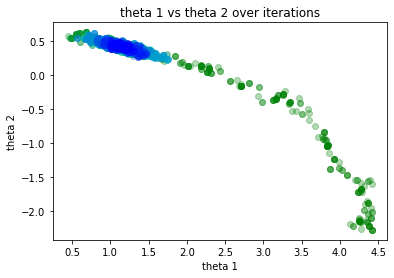

In [8]:

# Main code execution
# Load the data as a pandas dataframe
df = pd.read_csv("dataexercise2.csv")

# Convert the dataframe to a numpy array (for easier manipulation)
arr = df.to_numpy()

# Split the dataset
# first 4 columns are features (x matrix)
# last column is label (y vector)
x = arr[:, :-1]
y = arr[:, -1]

# Set initial parameters
featNum = x.shape[1]
std0 = 4
thetasInit = np.random.multivariate_normal(np.zeros(featNum), std0**2*np.eye(featNum))
iters = 5000

cur_thetas, acc_thetas, rej_thetas = \
    execMetropolisHastings(thetasInit, iters, x, y)

acceptance_rate = len(acc_thetas)/iters
print("Acceptance rate is {}".format(acceptance_rate))

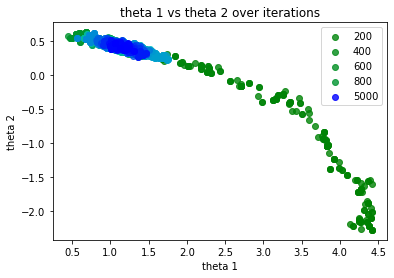

In [38]:
# plot theta1 vs theta2
initCol = Color("green")
finCol = Color("blue")
colorSpectrum = list(initCol.range_to(finCol, len(cur_thetas)))
fig, ax = plt.subplots()
for i in range(len(colorSpectrum)):
    if (((i+1) % 200 == 0) and (i+1 < 1000)) or (i+1 == iters):
	    ax.scatter(cur_thetas[i, 0], cur_thetas[i, 1], alpha=0.8, c=str(colorSpectrum[i]),
                   label=i+1)
    else:
        ax.scatter(cur_thetas[i, 0], cur_thetas[i, 1], alpha=0.8, c=str(colorSpectrum[i]))

plt.xlabel("theta 1")
plt.ylabel("theta 2")
plt.title("theta 1 vs theta 2 over iterations")
plt.legend()
plt.show()
fig.savefig('plot4.png')

In [39]:
#fig.savefig('plot3.png')
lim = 280
meanPost = np.mean(cur_thetas[280:, :], axis=0)
print("Mean posterior theta is: {}".format(meanPost))

Mean posterior theta is: [ 1.14712474  0.41964996  0.01967746 -0.03759524]


In [126]:
# NEXT EXERCISE


4703

In [4]:
### Exercise 5
# basic imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import invgamma

In [5]:
# Define functions to modularize the script
def calcPriorTheta(thetas, std0=4, featNum=4):
	# Calculate the prior of thetas, based on normal distribution
	# thetas: 4x1 array of parameters
	# std0: standard deviation set by the problem statement
	# featNum: Number of features loaded
	dist = multivariate_normal(mean=np.zeros(featNum), cov=std0**2*np.eye(featNum))
	return dist.pdf(thetas.T)

def calcLogPostTheta(thetas, x, y, sigma=4):
	# Calculate the posterior of theta given data, without the
	# regularization parameter
	# thetas: 4x1 array of parameters
	# x: 2d given dataset
	# y: 1d labels of given dataset
	log_likelihood = 0
	for i in range(y.shape[0]):
		log_likelihood += -np.exp(x[i].T @ thetas)\
                          + y[i]*x[i].T @ thetas\
                          - np.log(math.factorial(y[i]))
	log_prior = calcPriorTheta(thetas, std0=sigma)
	return (log_likelihood + log_prior)[0]

def acceptUpdate(logPostThetasCur, logPostThetasNew):
	# Calculate whether currents thetas will be updated with the new thetas
	# based on the acceptance criterion.
	# logPostThetasCur
	# logPostThetasNew
	logAcceptance = logPostThetasNew - logPostThetasCur
	if logAcceptance > 0: # then a = 1, sure update
		return True
	else:
		# Sample from uniform distribution
		logU = np.log(np.random.uniform(0, 1))
		return logAcceptance > logU

def execGibbsSamples(thetasInit, iters, x, y):
	# logPosterior: the log posterior probability of thetas
	# thetasInit: initialization of theta parameters
	# iters: number of iterations
	# x: 2d given dataset
	# y: 1d labels of given dataset

	# Create lists to store the accepted, rejected and current thetas
    acc_thetas = []
    rej_thetas = []
    cur_thetas = np.zeros((iters, featNum))
    sigmas = []

	# Initialize theta parameters
    thetasCur = np.reshape(thetasInit, (-1, 1))

	# Initialized proposed sigma
    sigma_prop = 0.08
    alpha = 0.2
    beta = 0.2

	# Begin the loop
    for iter in range(iters):
        # First update the sigma, based on the inversed gamma distribution
        sigma = invgamma.rvs(a=alpha + featNum/2, scale=beta + 0.5*np.linalg.norm(thetasCur)**2)
        sigmas.append(sigma)
        # Compute the new theta parameters with Random Walk
        thetasNew = thetasCur + np.random.normal(0, sigma_prop, (featNum, 1))
        thetasCurPost = calcLogPostTheta(thetasCur, x, y, sigma=sigma)
        thetasNewPost = calcLogPostTheta(thetasNew, x, y, sigma=sigma)
        if acceptUpdate(thetasCurPost, thetasNewPost):
			# Update thetas
            thetasCur = thetasNew
            acc_thetas.append(thetasNew)
        else:
            rej_thetas.append(thetasNew)
		# Collect current theta parameters
        cur_thetas[iter] = thetasCur[:, 0]

    return cur_thetas, acc_thetas, rej_thetas, sigmas

In [6]:
# Main code execution
# Load the data as a pandas dataframe
df = pd.read_csv("dataexercise2.csv")

# Convert the dataframe to a numpy array (for easier manipulation)
arr = df.to_numpy()

# Split the dataset
# first 4 columns are features (x matrix)
# last column is label (y vector)
x = arr[:, :-1]
y = arr[:, -1]

# Set initial parameters
featNum = x.shape[1]
std0 = 4
thetasInit = np.random.multivariate_normal(np.zeros(featNum), std0**2*np.eye(featNum))
iters = 5000

cur_thetas, acc_thetas, rej_thetas, sigmas =\
    execGibbsSamples(thetasInit, iters, x, y)

acceptance_rate = len(acc_thetas)/iters
print("Acceptance rate is {}".format(acceptance_rate))

Acceptance rate is 0.3198


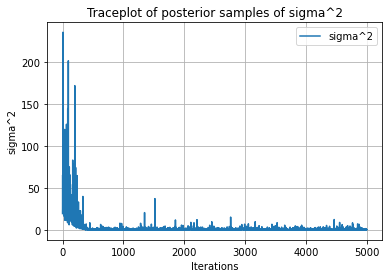

In [9]:
# plot traceplot
plt.plot(np.arange(len(sigmas)), sigmas, label="sigma^2")
plt.xlabel("Iterations")
plt.ylabel("sigma^2")
plt.title("Traceplot of posterior samples of sigma^2")
plt.legend()
plt.grid()
plt.savefig('plot5_1.png')
plt.show()

